# Privacy Attacks

In [1]:
import os
import matplotlib.pyplot as plt

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [2]:
torch.set_num_threads(1)
cwd = os.path.join(os.getcwd(), '..', '..')

p_indian_list = [0.005, 0.01, 0.05,
                 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9,
                 0.95, 0.99, 0.995]
out_rate = 1000

## Attack sketches

In [3]:
all_cores_dir = os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny', 'cores')

acc_diffs_cores = []
for p in p_indian_list:
    p_acc_diff = []
    for idx in range(10):
        cores_dir = os.path.join(all_cores_dir, str(p), str(idx))
        files_lst = os.listdir(cores_dir)
        for f in files_lst:
            test_acc = float(f.split('_')[1])
            sketch_acc = float(f.split('_')[2][:-3])
            p_acc_diff.append(sketch_acc - test_acc)
        
    p_acc_diff = torch.Tensor(p_acc_diff)
    acc_diffs_cores.append((p, (p_acc_diff.mean(), p_acc_diff.std())))

acc_diffs_cores = dict(acc_diffs_cores)
acc_diffs_cores

{0.005: (tensor(0.0359), tensor(0.0326)),
 0.01: (tensor(0.0321), tensor(0.0342)),
 0.05: (tensor(0.0187), tensor(0.0339)),
 0.1: (tensor(0.0100), tensor(0.0367)),
 0.2: (tensor(0.0186), tensor(0.0376)),
 0.3: (tensor(0.0053), tensor(0.0377)),
 0.5: (tensor(0.0103), tensor(0.0414)),
 0.7: (tensor(0.0066), tensor(0.0432)),
 0.8: (tensor(-0.0006), tensor(0.0444)),
 0.9: (tensor(0.0127), tensor(0.0449)),
 0.95: (tensor(0.0055), tensor(0.0414)),
 0.99: (tensor(0.0090), tensor(0.0422)),
 0.995: (tensor(0.0023), tensor(0.0433))}

In [4]:
all_recores_dir = os.path.join(cwd,'results', '6_privacy', 'fffc_tiny', 'recores')

acc_diffs_recores = []
for p in p_indian_list:
    p_acc_diff = []
    for idx in range(10):
        recores_dir = os.path.join(all_recores_dir, str(p), str(idx))
        files_lst = os.listdir(recores_dir)
        for f in files_lst:
            test_acc = float(f.split('_')[1])
            sketch_acc = float(f.split('_')[2][:-3])
            p_acc_diff.append(sketch_acc - test_acc)
        
    p_acc_diff = torch.Tensor(p_acc_diff)
    acc_diffs_recores.append((p, (p_acc_diff.mean(), p_acc_diff.std())))

acc_diffs_recores = dict(acc_diffs_recores)
acc_diffs_recores

{0.005: (tensor(-0.0008), tensor(0.0286)),
 0.01: (tensor(0.0067), tensor(0.0279)),
 0.05: (tensor(-0.0011), tensor(0.0304)),
 0.1: (tensor(0.0004), tensor(0.0312)),
 0.2: (tensor(-0.0008), tensor(0.0353)),
 0.3: (tensor(0.0013), tensor(0.0351)),
 0.5: (tensor(0.0012), tensor(0.0377)),
 0.7: (tensor(-0.0021), tensor(0.0382)),
 0.8: (tensor(-0.0032), tensor(0.0357)),
 0.9: (tensor(0.0146), tensor(0.0299)),
 0.95: (tensor(0.0062), tensor(0.0323)),
 0.99: (tensor(-0.0005), tensor(0.0385)),
 0.995: (tensor(0.0036), tensor(0.0388))}

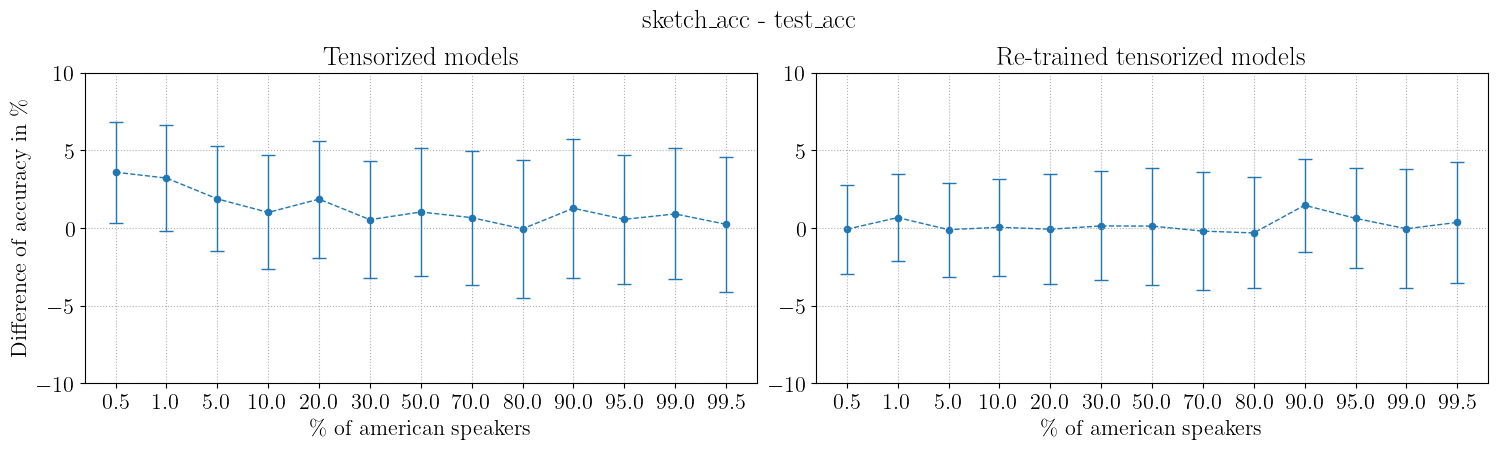

In [5]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
# colors = ['black', 'tab:blue', 'tab:orange', 'tab:green']

fig, axs = plt.subplots(1, 2, figsize=(15, 4.5))
p_str = [str(p * 100) for p in p_indian_list]

# Cores
# -----
means = torch.stack(list(map(lambda t: t[0] * 100,
                             acc_diffs_cores.values()))).tolist()
stds = torch.stack(list(map(lambda t: t[1] * 100,
                            acc_diffs_cores.values()))).tolist()

axs[0].errorbar(x=p_str, y=means, yerr=stds, capsize=5.,
                linestyle='--', linewidth=1., color='tab:blue')
axs[0].scatter(x=p_str, y=means, marker='o', s=20., color='tab:blue')

# Set axes
axs[0].set_xlabel('\% of american speakers')
axs[0].set_ylabel('Difference of accuracy in \%')
axs[0].set_title('Tensorized models')

axs[0].set_ylim(-10, 10)
axs[0].yaxis.grid(linestyle=':')
axs[0].xaxis.grid(linestyle=':')

# Recores
# -------
means = torch.stack(list(map(lambda t: t[0] * 100,
                             acc_diffs_recores.values()))).tolist()
stds = torch.stack(list(map(lambda t: t[1] * 100,
                            acc_diffs_recores.values()))).tolist()

axs[1].errorbar(x=p_str, y=means, yerr=stds, capsize=5.,
                linestyle='--', linewidth=1., color='tab:blue')
axs[1].scatter(x=p_str, y=means, marker='o', s=20., color='tab:blue')

# Set axes
axs[1].set_xlabel('\% of american speakers')
axs[1].set_title('Re-trained tensorized models')

axs[1].set_ylim(-10, 10)
axs[1].yaxis.grid(linestyle=':')
axs[1].xaxis.grid(linestyle=':')


fig.suptitle('sketch_acc - test_acc')

plt.tight_layout(pad=0.5)
plt.show()

## NNs

In [6]:
accs = torch.load(os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny',
                               'attacks', 'plot_attack_bb_nn.pt'),
                  weights_only=False)
accs = dict(accs)
accs

{0.005: (tensor(0.8646), tensor(0.0079)),
 0.01: (tensor(0.8664), tensor(0.0080)),
 0.05: (tensor(0.8752), tensor(0.0081)),
 0.1: (tensor(0.8855), tensor(0.0091)),
 0.2: (tensor(0.8998), tensor(0.0079)),
 0.3: (tensor(0.9062), tensor(0.0077)),
 0.5: (tensor(0.9095), tensor(0.0078)),
 0.7: (tensor(0.9000), tensor(0.0081)),
 0.8: (tensor(0.8907), tensor(0.0091)),
 0.9: (tensor(0.8719), tensor(0.0087)),
 0.95: (tensor(0.8652), tensor(0.0087)),
 0.99: (tensor(0.8565), tensor(0.0079)),
 0.995: (tensor(0.8543), tensor(0.0084))}

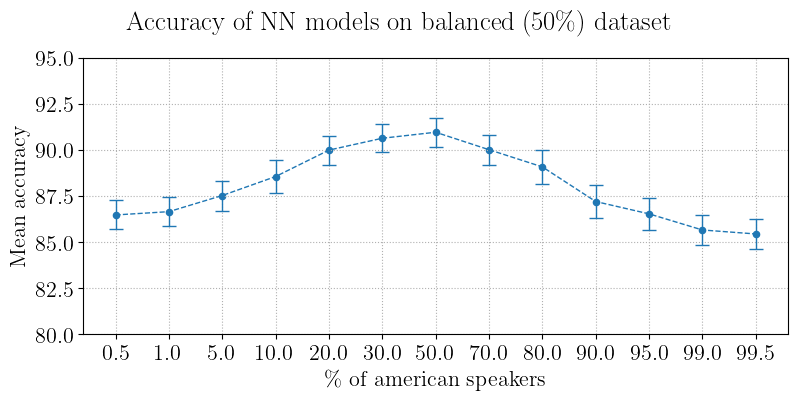

In [7]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
# colors = ['black', 'tab:blue', 'tab:orange', 'tab:green']

fig, axs = plt.subplots(1, 1, figsize=(8, 4))
p_str = [str(p * 100) for p in p_indian_list]

# NNs
# ---
means = torch.stack(list(map(lambda t: t[0] * 100, accs.values()))).tolist()
stds = torch.stack(list(map(lambda t: t[1] * 100, accs.values()))).tolist()

axs.errorbar(x=p_str, y=means, yerr=stds, capsize=5.,
             linestyle='--', linewidth=1., color='tab:blue')
axs.scatter(x=p_str, y=means, marker='o', s=20., color='tab:blue')

# Set axes
axs.set_xlabel('\% of american speakers')
axs.set_ylabel('Mean accuracy')

axs.set_ylim(80, 95)
axs.yaxis.grid(linestyle=':')
axs.xaxis.grid(linestyle=':')


fig.suptitle('Accuracy of NN models on balanced (50\%) dataset')

plt.tight_layout(pad=0.5)
plt.show()

In [8]:
# Create BB dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks', 'nn')

datasets = {}
for p in p_indian_list[:6]:
    samples = []
    labels = []
    for idx in range(10):
        for s in range(25):
            for aux_p in [p, 1 - p]:
                sample = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                samples.append(sample)
                labels.append(label)
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [9]:
# Black-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, :200], y_train)
        
        train_score = clf.score(X_train[:, :200], y_train)
        test_score = clf.score(X_test[:, :200], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(1.)
0.01 tensor(1.) tensor(1.)
0.05 tensor(1.) tensor(1.)
0.1 tensor(1.) tensor(1.)
0.2 tensor(1.) tensor(1.)
0.3 tensor(1.) tensor(1.)


In [10]:
# White-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :200]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, 200:]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        X_train = torch.cat([torch.Tensor(X_train_bb),
                             torch.Tensor(X_train_wb)], dim=1)
        
        y_train = y[train]
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :200]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, 200:]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        X_test = torch.cat([torch.Tensor(X_test_bb),
                            torch.Tensor(X_test_wb)], dim=1)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(1.)
0.01 tensor(1.) tensor(1.)
0.05 tensor(1.) tensor(1.)
0.1 tensor(1.) tensor(1.)
0.2 tensor(1.) tensor(1.)
0.3 tensor(1.) tensor(0.9820)


In [11]:
# Only white-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 200:], y_train)
        
        train_score = clf.score(X_train[:, 200:], y_train)
        test_score = clf.score(X_test[:, 200:], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9960)
0.01 tensor(1.) tensor(0.9980)
0.05 tensor(1.) tensor(1.)
0.1 tensor(1.) tensor(0.9980)
0.2 tensor(1.) tensor(0.9840)
0.3 tensor(1.) tensor(0.8920)


In [12]:
X, y = datasets[0.005]

In [13]:
X[:10, [0, 1, 50, 51, 100, 101, 150, 151]]

tensor([[-1.5573,  3.7514,  1.8980,  3.2963, -0.3232,  3.4028,  1.6684,  0.2790],
        [ 1.4109,  5.3250,  1.1132,  5.5974, -0.4065,  0.8785, -0.5351, -1.9195],
        [-1.9011,  5.4612,  2.7877,  5.6235,  0.0451,  3.1353,  2.6975,  0.4537],
        [ 1.2456,  4.9370,  0.7146,  4.7032, -0.7660,  1.0064, -0.9565, -1.4887],
        [-1.1025,  3.4128,  2.2564,  3.7832, -0.3877,  3.4905,  1.3074, -0.2152],
        [ 1.1723,  4.7746,  0.5665,  6.3777, -0.4278,  1.1649, -0.6238, -0.8411],
        [-1.3277,  4.1302,  3.4425,  3.8112, -0.4955,  3.8415,  2.7319,  0.2266],
        [ 1.0947,  4.0545,  1.6051,  5.3804, -0.1692,  1.0927, -0.5899, -1.8119],
        [-1.3472,  4.1861,  2.5781,  5.0106, -0.4701,  3.1479,  2.0357,  0.3087],
        [ 1.3656,  3.4045,  0.7995,  4.5944, -0.6108,  1.3136,  0.1584, -1.6956]])

In [14]:
y[:10]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

In [15]:
X[50:60, [0, 1, 50, 51, 100, 101, 150, 151]]

tensor([[-1.3452,  4.8242,  2.6389,  5.5523, -0.0833,  4.0437,  1.8113,  0.1257],
        [ 1.1916,  5.2272,  1.0483,  7.2171, -0.1941,  1.0802, -0.4986, -1.2966],
        [-1.4390,  3.4182,  2.0138,  3.3712, -0.0429,  4.2239,  3.1849,  0.6550],
        [ 1.6564,  4.8156,  1.6148,  8.3047, -0.4808,  0.9475, -0.6773, -1.3748],
        [-1.3124,  4.3705,  2.0177,  4.7281, -0.2489,  4.0193,  1.7689, -0.1339],
        [ 0.9941,  2.8921,  0.4443,  6.1740, -0.1177,  1.1258, -0.2955, -1.1030],
        [-1.4081,  4.6775,  2.4160,  4.6126, -0.1403,  5.5726,  2.4542,  0.5242],
        [ 1.1449,  4.5895,  1.5357,  4.4679, -0.5241,  1.3938, -1.1706, -1.6019],
        [-1.8745,  6.2077,  2.1542,  9.0493,  0.1921,  3.8226,  1.4705,  0.6527],
        [ 1.3712,  6.6142,  1.4435, 11.7672, -0.4156,  0.8120, -0.6930, -1.5051]])

In [16]:
y[50:60]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

In [17]:
X[100:110, [0, 1, 50, 51, 100, 101, 150, 151]]

tensor([[-1.7276,  5.0429,  2.1502,  4.5104, -0.6801,  2.8356,  1.3722,  0.2300],
        [ 1.3982,  4.7126,  1.1339,  7.0931, -0.0692,  0.9229, -0.3882, -1.1772],
        [-1.6256,  5.2585,  2.4433,  4.8655,  0.1897,  3.8159,  1.6924,  0.0156],
        [ 1.0247,  5.1755,  1.2578,  6.2523,  0.1926,  0.6957, -0.8923, -0.9541],
        [-1.5452,  6.0506,  1.9620,  6.8341,  0.3484,  4.9355,  2.4823,  0.1433],
        [ 1.1118,  3.5285,  0.7016,  5.0399, -0.6705,  1.0653, -0.8051, -0.9946],
        [-1.5810,  4.2834,  1.5663,  5.1953, -0.0910,  3.0360,  1.7646,  0.2623],
        [ 0.9527,  4.0474,  1.3326,  4.8894,  0.1386,  1.1607, -0.3981, -0.7402],
        [-2.0081,  5.8180,  2.1391,  4.0200, -0.4067,  4.5808,  3.3096,  0.1440],
        [ 1.2348,  3.5576,  0.8523,  5.9320, -0.2315,  0.9943, -0.5654, -0.7619]])

In [18]:
y[100:110]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

## MPS

In [19]:
# Create BB dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks', 'cores')

datasets = {}
for p in p_indian_list[:6]:
    samples = []
    labels = []
    for idx in range(10):
        for s in range(25):
            for aux_p in [p, 1 - p]:
                sample = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                samples.append(sample)
                labels.append(label)
    
    min_len = samples[0].size(0)
    for s in samples[1:]:
        if s.size(0) < min_len:
            min_len = s.size(0)
    
    samples = [s[:min_len] for s in samples]
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [20]:
# Black-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, :200], y_train)
        
        train_score = clf.score(X_train[:, :200], y_train)
        test_score = clf.score(X_test[:, :200], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9960)
0.01 tensor(1.) tensor(0.9980)
0.05 tensor(1.) tensor(1.)
0.1 tensor(1.) tensor(0.9980)
0.2 tensor(1.) tensor(1.)
0.3 tensor(1.) tensor(0.9900)


In [21]:
# White-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :200]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, 200:]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        X_train = torch.cat([torch.Tensor(X_train_bb),
                             torch.Tensor(X_train_wb)], dim=1)
        
        y_train = y[train]
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :200]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, 200:]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        X_test = torch.cat([torch.Tensor(X_test_bb),
                            torch.Tensor(X_test_wb)], dim=1)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9960)
0.01 tensor(1.) tensor(0.9700)
0.05 tensor(1.) tensor(0.9960)
0.1 tensor(1.) tensor(0.9820)
0.2 tensor(1.) tensor(0.9940)
0.3 tensor(1.) tensor(0.9440)


In [22]:
# Only white-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 200:], y_train)
        
        train_score = clf.score(X_train[:, 200:], y_train)
        test_score = clf.score(X_test[:, 200:], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9580)
0.01 tensor(1.) tensor(0.9580)
0.05 tensor(1.) tensor(0.9480)
0.1 tensor(1.) tensor(0.9140)
0.2 tensor(1.) tensor(0.9520)
0.3 tensor(1.) tensor(0.9220)


## Re-trained MPS

In [23]:
# Create BB dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks', 'recores')

datasets = {}
for p in p_indian_list[:6]:
    samples = []
    labels = []
    for idx in range(10):
        for s in range(25):
            for aux_p in [p, 1 - p]:
                sample = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                samples.append(sample)
                labels.append(label)
    
    min_len = samples[0].size(0)
    for s in samples[1:]:
        if s.size(0) < min_len:
            min_len = s.size(0)
    
    samples = [s[:min_len] for s in samples]
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [24]:
# Black-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, :200], y_train)
        
        train_score = clf.score(X_train[:, :200], y_train)
        test_score = clf.score(X_test[:, :200], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9800)
0.01 tensor(0.9971) tensor(0.9720)
0.05 tensor(0.9996) tensor(0.9560)
0.1 tensor(0.9902) tensor(0.9240)
0.2 tensor(1.) tensor(0.9900)
0.3 tensor(1.) tensor(0.9800)


In [25]:
# White-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :200]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, 200:]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        X_train = torch.cat([torch.Tensor(X_train_bb),
                             torch.Tensor(X_train_wb)], dim=1)
        
        y_train = y[train]
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :200]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, 200:]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        X_test = torch.cat([torch.Tensor(X_test_bb),
                            torch.Tensor(X_test_wb)], dim=1)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9720)
0.01 tensor(1.) tensor(0.9540)
0.05 tensor(1.) tensor(0.9500)
0.1 tensor(1.) tensor(0.9180)
0.2 tensor(1.) tensor(0.9620)
0.3 tensor(1.) tensor(0.9060)


In [26]:
# Only white-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 200:], y_train)
        
        train_score = clf.score(X_train[:, 200:], y_train)
        test_score = clf.score(X_test[:, 200:], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9580)
0.01 tensor(1.) tensor(0.9540)
0.05 tensor(1.) tensor(0.9480)
0.1 tensor(1.) tensor(0.9140)
0.2 tensor(1.) tensor(0.9520)
0.3 tensor(1.) tensor(0.9220)


## Re-trained private MPS

In [27]:
# Create BB dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks', 'priv_recores')

datasets = {}
for p in p_indian_list[:6]:
    samples = []
    labels = []
    for idx in range(10):
        for s in range(25):
            for aux_p in [p, 1 - p]:
                sample = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                samples.append(sample)
                labels.append(label)
    
    min_len = samples[0].size(0)
    for s in samples[1:]:
        if s.size(0) < min_len:
            min_len = s.size(0)
    
    samples = [s[:min_len] for s in samples]
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [28]:
# Black-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, :200], y_train)
        
        train_score = clf.score(X_train[:, :200], y_train)
        test_score = clf.score(X_test[:, :200], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.9800)
0.01 tensor(0.9971) tensor(0.9720)
0.05 tensor(0.9993) tensor(0.9560)
0.1 tensor(0.9900) tensor(0.9240)
0.2 tensor(1.) tensor(0.9880)
0.3 tensor(1.) tensor(0.9800)


In [29]:
# White-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :200]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, 200:]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        X_train = torch.cat([torch.Tensor(X_train_bb),
                             torch.Tensor(X_train_wb)], dim=1)
        
        y_train = y[train]
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :200]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, 200:]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        X_test = torch.cat([torch.Tensor(X_test_bb),
                            torch.Tensor(X_test_wb)], dim=1)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.8120)
0.01 tensor(1.) tensor(0.5100)
0.05 tensor(1.) tensor(0.6120)
0.1 tensor(1.) tensor(0.5880)
0.2 tensor(1.) tensor(0.7360)
0.3 tensor(1.) tensor(0.6560)


In [30]:
# Only white-box
for p in p_indian_list[:6]:
    train_scores = []
    test_scores = []
    for i in range(10):
        train = torch.cat([torch.arange(0, i * 50),
                           torch.arange((i + 1) * 50, 500)], dim=0)
        test = torch.arange(i * 50, (i + 1) * 50)

        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        clf = LogisticRegression() #random_state=0)
        clf = clf.fit(X_train[:, 200:], y_train)
        
        train_score = clf.score(X_train[:, 200:], y_train)
        test_score = clf.score(X_test[:, 200:], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean())

0.005 tensor(1.) tensor(0.5160)
0.01 tensor(1.) tensor(0.4980)
0.05 tensor(1.) tensor(0.5220)
0.1 tensor(1.) tensor(0.5220)
0.2 tensor(1.) tensor(0.5420)
0.3 tensor(1.) tensor(0.4580)
